In [1]:
#@title Self-guidance modules
import torch
import diffusers
import torch.nn.functional as F
import torchvision.transforms.functional as TF

import math

from utils import concat_images, search_sequence_numpy
from edits import change_size, change_centroid, normalized_attention, appearance_difference, silhouette_difference
from pipeline import SelfGuidanceSDXLPipeline


class SelfGuidanceAttnProcessor:
    r"""
    Default processor for performing attention-related computations.
    """

    def __call__(
        self,
        attn: diffusers.models.attention_processor.Attention,
        hidden_states,
        encoder_hidden_states=None,
        attention_mask=None,
        temb=None,
    ):
        residual = hidden_states

        if attn.spatial_norm is not None:
            hidden_states = attn.spatial_norm(hidden_states, temb)

        input_ndim = hidden_states.ndim

        if input_ndim == 4:
            batch_size, channel, height, width = hidden_states.shape
            hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)

        batch_size, sequence_length, _ = (
            hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
        )
        attention_mask = attn.prepare_attention_mask(attention_mask, sequence_length, batch_size)

        if attn.group_norm is not None:
            hidden_states = attn.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)

        query = attn.to_q(hidden_states)

        if encoder_hidden_states is None:
            encoder_hidden_states = hidden_states
        elif attn.norm_cross:
            encoder_hidden_states = attn.norm_encoder_hidden_states(encoder_hidden_states)

        key = attn.to_k(encoder_hidden_states)
        value = attn.to_v(encoder_hidden_states)

        query = attn.head_to_batch_dim(query)
        key = attn.head_to_batch_dim(key)
        value = attn.head_to_batch_dim(value)

        attention_probs = attn.get_attention_scores(query, key, attention_mask)

        ### SELF GUIDANCE
        scores_ = attention_probs.reshape(len(query), -1, *attention_probs.shape[1:]).mean(1)
        h=w=math.isqrt(scores_.shape[1])
        scores_ = scores_.reshape(len(scores_), h, w, -1)
        global _SG_RES
        if _SG_RES != scores_.shape[2]:
          scores_ = TF.resize(scores_.permute(0,3,1,2), _SG_RES, antialias=True).permute(0,2,3,1)
        try:
          global save_aux
          if not save_aux:
            len_=len(attn._aux['attn'])
            del attn._aux['attn']
            attn._aux['attn'] = [None]*len_ + [scores_]
          else:
            attn._aux['attn'][-1] = attn._aux['attn'][-1].cpu()
            attn._aux['attn'].append(scores_)
        except:
          del attn._aux['attn']
          attn._aux = {'attn': [scores_]}
        ### END SELF GUIDANCE

        hidden_states = torch.bmm(attention_probs, value)
        hidden_states = attn.batch_to_head_dim(hidden_states)

        # linear proj
        hidden_states = attn.to_out[0](hidden_states)
        # dropout
        hidden_states = attn.to_out[1](hidden_states)

        if input_ndim == 4:
            hidden_states = hidden_states.transpose(-1, -2).reshape(batch_size, channel, height, width)

        if attn.residual_connection:
            hidden_states = hidden_states + residual

        hidden_states = hidden_states / attn.rescale_output_factor

        return hidden_states

class SelfGuidanceAttnProcessor2_0:
    r"""
    Processor for implementing scaled dot-product attention (enabled by default if you're using PyTorch 2.0).
    """

    def __init__(self):
        if not hasattr(F, "scaled_dot_product_attention"):
            raise ImportError("AttnProcessor2_0 requires PyTorch 2.0, to use it, please upgrade PyTorch to 2.0.")

    def __call__(
        self,
        attn: diffusers.models.attention_processor.Attention,
        hidden_states,
        encoder_hidden_states=None,
        attention_mask=None,
        temb=None,
    ):
        residual = hidden_states

        if attn.spatial_norm is not None:
            hidden_states = attn.spatial_norm(hidden_states, temb)

        input_ndim = hidden_states.ndim

        if input_ndim == 4:
            batch_size, channel, height, width = hidden_states.shape
            hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)

        batch_size, sequence_length, _ = (
            hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
        )

        if attention_mask is not None:
            attention_mask = attn.prepare_attention_mask(attention_mask, sequence_length, batch_size)
            # scaled_dot_product_attention expects attention_mask shape to be
            # (batch, heads, source_length, target_length)
            attention_mask = attention_mask.view(batch_size, attn.heads, -1, attention_mask.shape[-1])

        if attn.group_norm is not None:
            hidden_states = attn.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)

        query = attn.to_q(hidden_states)

        if encoder_hidden_states is None:
            encoder_hidden_states = hidden_states
        elif attn.norm_cross:
            encoder_hidden_states = attn.norm_encoder_hidden_states(encoder_hidden_states)

        key = attn.to_k(encoder_hidden_states)
        value = attn.to_v(encoder_hidden_states)

        ### SELF GUIDANCE
        query_ = attn.head_to_batch_dim(query)
        key_ = attn.head_to_batch_dim(key)
        scores_ = attn.get_attention_scores(query_, key_, attention_mask)
        scores_ = scores_.reshape(len(query), -1, *scores_.shape[1:]).mean(1)
        h=w=math.isqrt(scores_.shape[1])
        scores_ = scores_.reshape(len(scores_), h, w, -1)
        global _SG_RES
        if _SG_RES != scores_.shape[2]:
          scores_ = TF.resize(scores_.permute(0,3,1,2), _SG_RES, antialias=True).permute(0,2,3,1)
        try:
          global save_aux
          if not save_aux:
            len_=len(attn._aux['attn'])
            del attn._aux['attn']
            attn._aux['attn'] = [None]*len_ + [scores_]
          else:
            attn._aux['attn'][-1] = attn._aux['attn'][-1].cpu()
            attn._aux['attn'].append(scores_)
        except:
          try: del attn._aux['attn']
          except: pass
          attn._aux = {'attn': [scores_]}
        ### END SELF GUIDANCE

        inner_dim = key.shape[-1]
        head_dim = inner_dim // attn.heads

        query = query.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)

        key = key.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)

        value = value.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)

        # the output of sdp = (batch, num_heads, seq_len, head_dim)
        # TODO: add support for attn.scale when we move to Torch 2.1
        hidden_states = F.scaled_dot_product_attention(
            query, key, value, attn_mask=attention_mask, dropout_p=0.0, is_causal=False
        )

        hidden_states = hidden_states.transpose(1, 2).reshape(batch_size, -1, attn.heads * head_dim)
        hidden_states = hidden_states.to(query.dtype)

        # linear proj
        hidden_states = attn.to_out[0](hidden_states)
        # dropout
        hidden_states = attn.to_out[1](hidden_states)

        if input_ndim == 4:
            hidden_states = hidden_states.transpose(-1, -2).reshape(batch_size, channel, height, width)

        if attn.residual_connection:
            hidden_states = hidden_states + residual

        hidden_states = hidden_states / attn.rescale_output_factor

        return hidden_states

In [2]:
#@title Initialize pipeline { form-width: "20%"}
use_ddpm = True # @param {type:"boolean"}

from functools import partial

base = SelfGuidanceSDXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",  use_safetensors=True, torch_dtype=torch.float16, variant="fp16", use_onnx=False
)
base.to("cuda:1")


attn_greenlist = []
base_name = "up_blocks.0.attentions.0.transformer_blocks"
for name, module in base.unet.up_blocks[0].attentions[0].transformer_blocks.named_children():
    for name_child, module_child in module.named_children():
        if name_child == "attn2":
            attn_greenlist.append(base_name+f".{name}.{name_child}")
base_name = "up_blocks.0.attentions.1.transformer_blocks"
for name, module in base.unet.up_blocks[0].attentions[1].transformer_blocks.named_children():
    for name_child, module_child in module.named_children():
        if name_child == "attn2":
            attn_greenlist.append(base_name+f".{name}.{name_child}")
#attn_greenlist = ["up_blocks.0.attentions.1.transformer_blocks.1.attn2",
#                  "up_blocks.0.attentions.1.transformer_blocks.2.attn2",
#                  "up_blocks.0.attentions.1.transformer_blocks.3.attn2",
#                  "up_blocks.0.attentions.1.transformer_blocks.4.attn2",
#                  "up_blocks.0.attentions.1.transformer_blocks.5.attn2"]

for name, block in base.unet.named_modules():
  if isinstance(block, (diffusers.models.unet_2d_blocks.CrossAttnDownBlock2D, diffusers.models.unet_2d_blocks.CrossAttnUpBlock2D, diffusers.models.unet_2d_blocks.UNetMidBlock2DCrossAttn)):
    for attn_name, attn in block.named_modules():
      full_name = name+'.'+attn_name
      if 'attn2' not in attn_name or (attn_greenlist and full_name not in attn_greenlist): continue
      if isinstance(attn, diffusers.models.attention_processor.Attention):
        if isinstance(attn.processor, diffusers.models.attention_processor.AttnProcessor2_0):
          attn.processor = SelfGuidanceAttnProcessor2_0()
        elif isinstance(attn.processor, diffusers.models.attention_processor.AttnProcessor):
          attn.processor = SelfGuidanceAttnProcessor()
        else:
          raise NotImplementedError("Self-guidance is not implemented for this attention processor")

if use_ddpm:
  print('Using DDPM as scheduler.')
  base.scheduler = diffusers.DDPMScheduler.from_config(base.scheduler.config)
def resave_aux_key(module, *args, old_key="attn", new_key="last_attn"):
  module._aux[new_key] = module._aux[old_key]
_SG_RES = 64
def resize(x):
  return TF.resize(x, _SG_RES, antialias=True)
def stash_to_aux(module, args, kwargs, output, mode, key="last_feats", args_idx=None, kwargs_key=None, fn_to_run=None):
  to_save = None
  if mode == "args":
    to_save = input
    if args_idx is not None: to_save = args[args_idx]
  elif mode == "kwargs":
    assert kwargs_key is not None
    to_save = kwargs[kwargs_key]
  elif mode == "output":
    to_save = output
  if fn_to_run is not None: to_save = fn_to_run(to_save)
  try:
    global save_aux
    if not save_aux:
      len_ = len(module._aux[key])
      del module._aux[key]
      module._aux[key] = [None]*len_ + [to_save]
    else:
      module._aux[key][-1] = module._aux[key][-1].cpu()
      module._aux[key].append(to_save)
  except:
    try: del module._aux[key]
    except: pass
    module._aux = {key: [to_save]}
# base.unet.up_blocks[2].register_forward_hook(partial(stash_to_aux,mode="kwargs", kwargs_key="hidden_states"), with_kwargs=True)
base.unet.up_blocks[2].register_forward_hook(partial(stash_to_aux,mode="output"), with_kwargs=True)
# base.unet.up_blocks[1].resnets[1].conv2.register_forward_hook(partial(stash_to_aux,mode="args", args_idx=0), with_kwargs=True)
base.unet.up_blocks[0].attentions[1].transformer_blocks[3].attn2.register_forward_hook(resave_aux_key)
# clear_output()

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.99it/s]


Using DDPM as scheduler.


In [3]:
attn_greenlist

['up_blocks.0.attentions.0.transformer_blocks.0.attn2',
 'up_blocks.0.attentions.0.transformer_blocks.1.attn2',
 'up_blocks.0.attentions.0.transformer_blocks.2.attn2',
 'up_blocks.0.attentions.0.transformer_blocks.3.attn2',
 'up_blocks.0.attentions.0.transformer_blocks.4.attn2',
 'up_blocks.0.attentions.0.transformer_blocks.5.attn2',
 'up_blocks.0.attentions.0.transformer_blocks.6.attn2',
 'up_blocks.0.attentions.0.transformer_blocks.7.attn2',
 'up_blocks.0.attentions.0.transformer_blocks.8.attn2',
 'up_blocks.0.attentions.0.transformer_blocks.9.attn2',
 'up_blocks.0.attentions.1.transformer_blocks.0.attn2',
 'up_blocks.0.attentions.1.transformer_blocks.1.attn2',
 'up_blocks.0.attentions.1.transformer_blocks.2.attn2',
 'up_blocks.0.attentions.1.transformer_blocks.3.attn2',
 'up_blocks.0.attentions.1.transformer_blocks.4.attn2',
 'up_blocks.0.attentions.1.transformer_blocks.5.attn2',
 'up_blocks.0.attentions.1.transformer_blocks.6.attn2',
 'up_blocks.0.attentions.1.transformer_blocks.7.

In [4]:
prompt="a photo of a chicken walking across the street with an Italian sports car waiting for it" 
if prompt is not None and isinstance(prompt, str):
    batch_size = 1
elif prompt is not None and isinstance(prompt, list):
    batch_size = len(prompt)
else:
    batch_size = prompt_embeds.shape[0]
num_images_per_prompt = 1
num_channels_latents = base.unet.config.in_channels
height = base.default_sample_size * base.vae_scale_factor
width = base.default_sample_size * base.vae_scale_factor

In [5]:
import torch
seed = 2
torch.manual_seed(seed)
import random
random.seed(seed)
import numpy as np
np.random.seed(seed)


In [6]:
generator = torch.Generator(device="cuda:1").manual_seed(seed)
latents = base.prepare_latents(batch_size * num_images_per_prompt, num_channels_latents, height, width, torch.float16, 
                               torch.device("cuda:1"), generator=generator, latents=None)

100%|██████████| 300/300 [00:43<00:00,  6.84it/s]


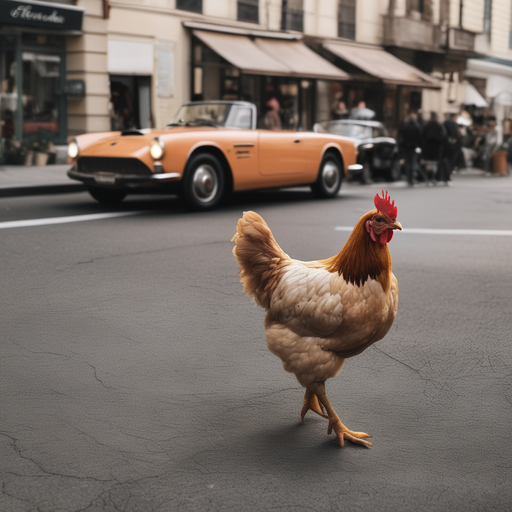

In [7]:
#@title Generate (for editing generated image below)

save_aux=True # @param {type:"boolean"}
n_img=1  # @param {type:"integer"}
generator = torch.Generator(device="cuda:1").manual_seed(seed)
out = base(prompt=[prompt]*n_img, num_inference_steps=300, generator=generator, save_aux=save_aux, latents=None).images
if save_aux: 
    aux = base.get_sg_aux()
concat_images(out)

In [17]:
#@title Generate with self-guidance
save_aux=False
aux_idx=0
n_img=1 # @param {type:"integer"}
processed_aux = {k:torch.utils._pytree.tree_map(lambda x: x[aux_idx:aux_idx+1].repeat_interleave(n_img, 0).cpu(), v) for k,v in aux.items()}
try: processed_aux = {k:torch.utils._pytree.tree_map(lambda x: x[aux_idx:aux_idx+1].repeat_interleave(n_img, 0).cpu(), v) for k,v in aux.items()}
except: pass
sg_edits = {
    ('last_attn', 'last_feats'): [{
        'words': ["photo", "chicken", "street", "Italian sports car"],
         'fn': appearance_difference,
         'weight': 0.3,
         'tgt': processed_aux,
         'threshold': 0.75,
         'kwargs': {}
     }, 
    ],
    'attn': [
        {
        'words': ["photo", "street", 'chicken'],
         'fn': silhouette_difference,
         'kwargs': {
                 # 'dx': -0.5
                 # 'sx': 1.5,
                 # 'sy': 1.5
             },
         'weight': 1.5,
          'tgt': processed_aux
        },
        # {
        #     'words': ["chicken"],
        #     'fn': change_size,
        #     'kwargs': {
        #       'shift': (0.05,),
        #     },
        #  'weight': 3.0,
        #},
        {
              'words': ["Italian sports car"],
              'fn': change_centroid,
              'kwargs': {
               'shift': (.1, .1),
               'relative': False
             },
             'weight': 4.0,
             # 'tgt': processed_aux
         },
    ]
}

# How many sampling steps to take
num_inference_steps = 300 # @param {type:"integer"}
# To avoid numerical underflow, scale loss by this amount and then divide gradients after backprop
sg_loss_rescale = 1000. # @param {type: "number"}
# Weight on self guidance term in sampling
sg_grad_wt = 1000. # @param {type: "number"}
# Step # to start self guidance.
sg_t_start = 20 # @param {type:"integer"}
# Step # to end self guidance.
sg_t_end = 280 # @param {type:"integer"}
generator = torch.Generator(device="cuda:1").manual_seed(seed)
out = base(prompt=[prompt]*n_img, sg_grad_wt=sg_grad_wt, sg_edits=sg_edits, num_inference_steps=num_inference_steps,
           sg_loss_rescale=sg_loss_rescale, debug=False, sg_t_start=sg_t_start, sg_t_end=sg_t_end, generator=generator, save_aux=save_aux, 
           latents=None).images#latents=latents).images
concat_images(out)

 31%|███       | 93/300 [00:55<02:27,  1.40it/s]

In [9]:
processed_aux.keys()

dict_keys(['attn', 'last_attn', 'last_feats'])

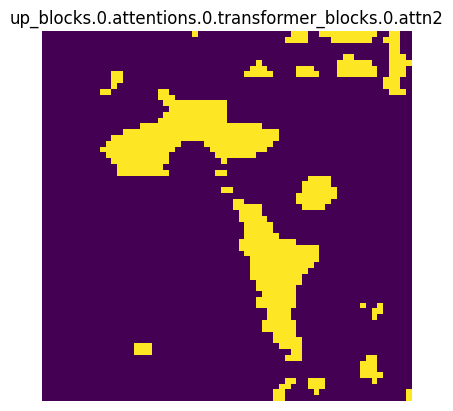

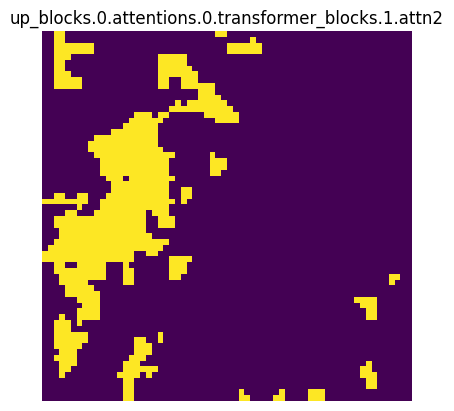

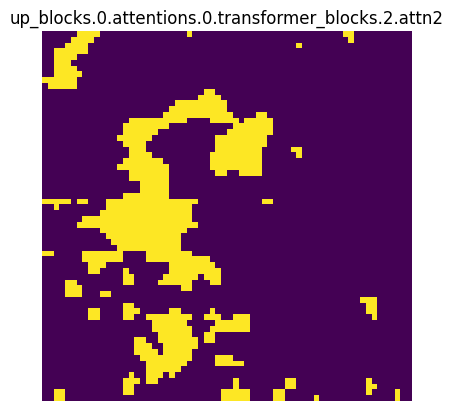

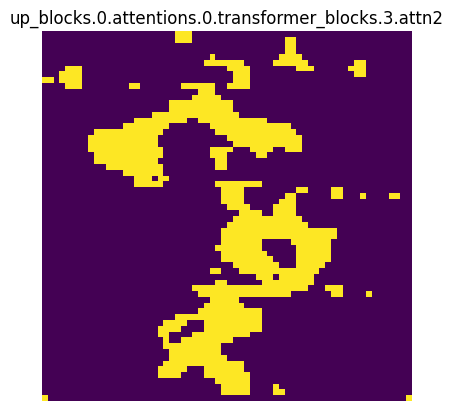

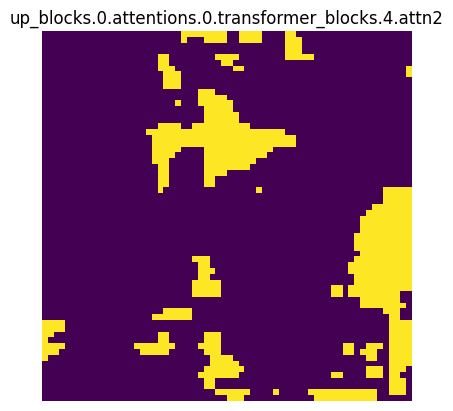

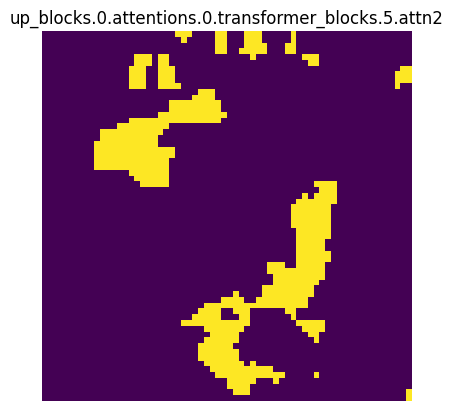

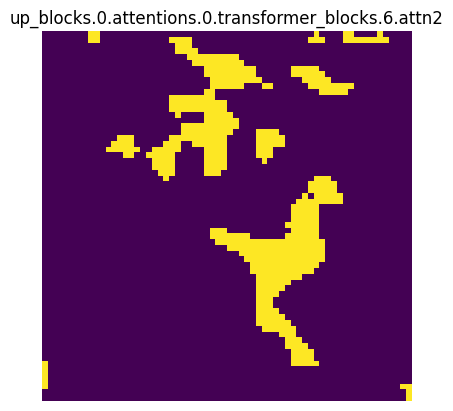

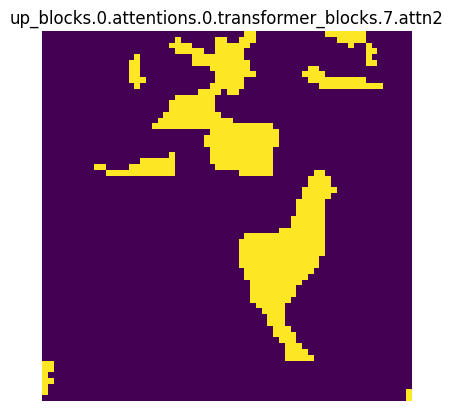

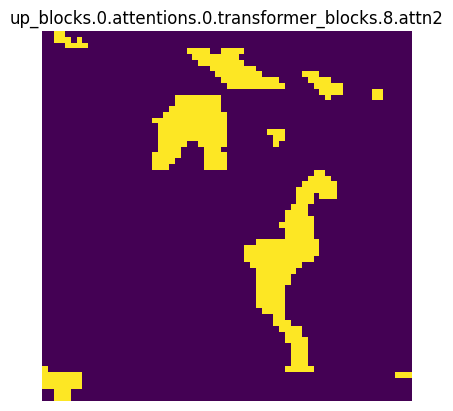

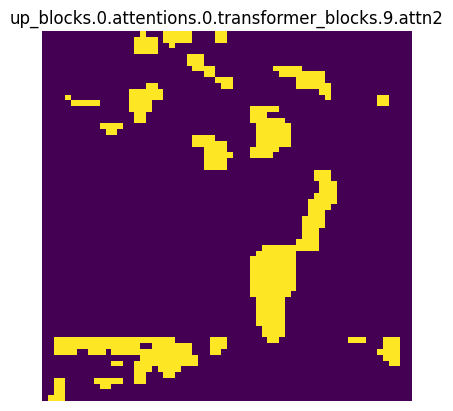

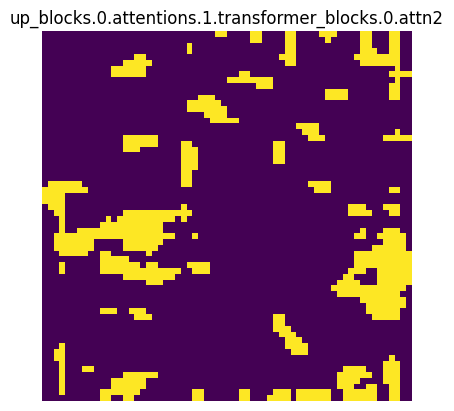

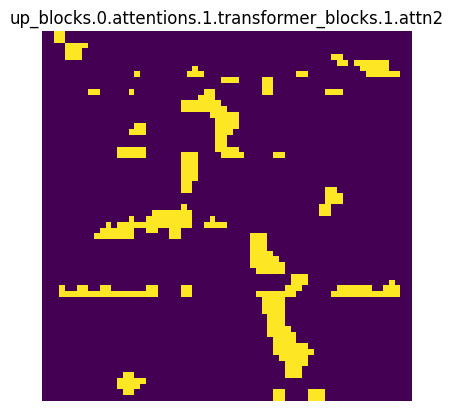

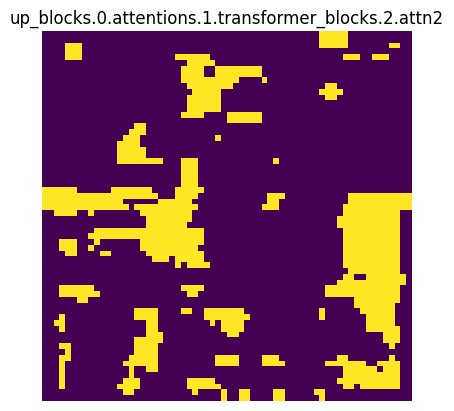

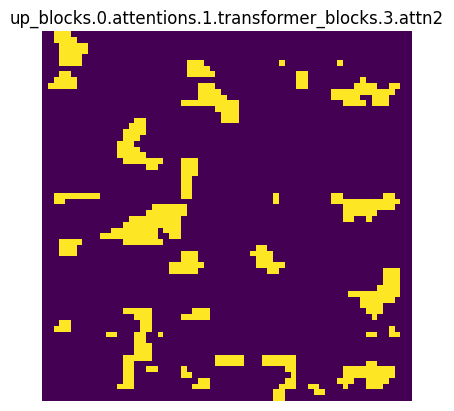

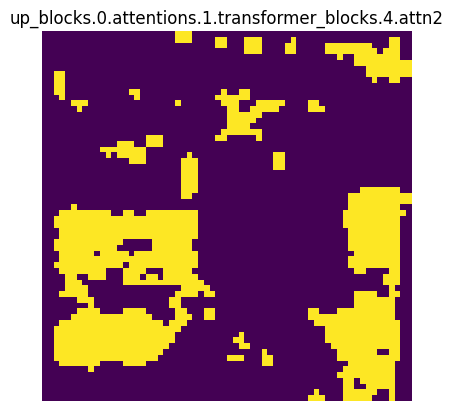

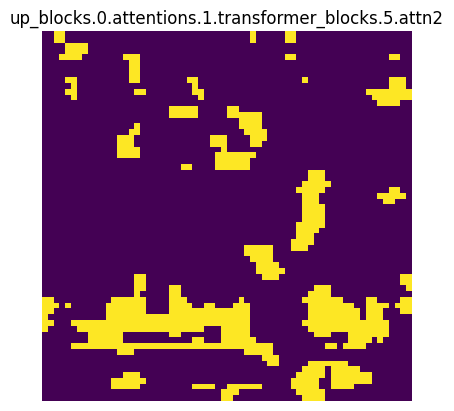

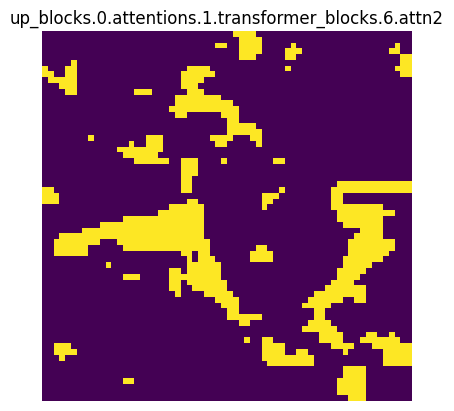

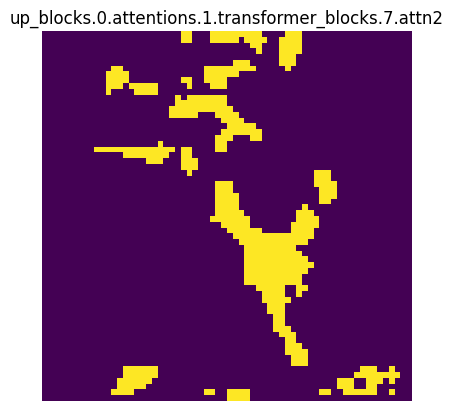

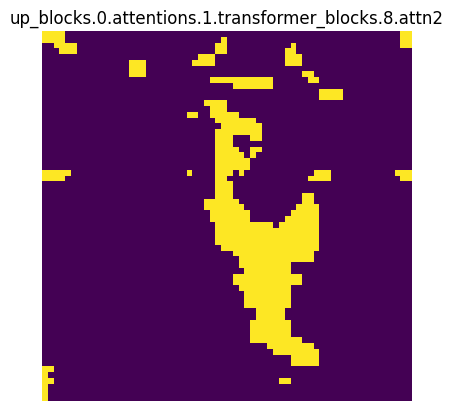

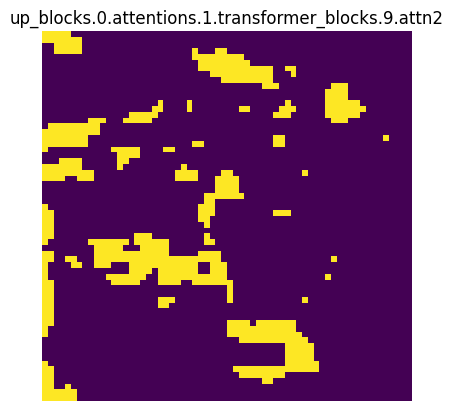

In [16]:
#@title Visualize attention (must check save_aux)
from matplotlib import pyplot as plt
prompt_text_ids = base.tokenizer(prompt, return_tensors='np')['input_ids'][0]
attn_words = "car"
word_ids = base.tokenizer(attn_words, return_tensors='np')['input_ids']
word_ids = word_ids[word_ids < 49406]
idxs = search_sequence_numpy(prompt_text_ids, word_ids)
# for k,v in {k:(torch.stack([_.cpu() for _ in v])[:].mean(0)[0][..., idxs].mean(-1)[None, ..., None])[0][...,0] for k,v in aux['attn'].items() if k.startswith('up')}.items():
for k,v in {k:normalized_attention(torch.stack([_.cpu() for _ in v])[:].mean(0)[0][..., idxs].mean(-1)[None, ..., None],hard=True,threshold=0.8)[0][...,0] for k,v in aux['attn'].items() if k.startswith('up')}.items():
  plt.figure()
  plt.title(k)
  plt.axis('off')
  plt.imshow(v)
  # break